In [1]:
import math
import random
import pickle
import datetime
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import defaultdict
from scipy.interpolate import griddata

In [2]:
CIs = {'90': 1.645, '95': 1.96, '99': 2.576}

In [3]:
Data_Root = '/data/haopeng/Diffusion/SBM/'

In [4]:
def comb(k):
    '''compute row and column of a k-th element in a lower-triangle'''
    row = int((math.sqrt(1+8*k)+1)/2)
    column = int(k-(row-1)*row/2)
    return [row, column]

def sample_pairs(li, num):
    ''' this func allows one to sample pairs without generating all possible pairs.
    '''
    total = int(len(li) * (len(li) - 1) / 2)
    if total > num:
        index = random.sample(range(total), num)
    else:
        print('This group is small, can not generate # of pairs required, return all pairs!')
        index = range(total)
    pairs = []
    for i in index:
        row, column = comb(i)
        pairs.append((li[row], li[column]))
    return pairs

def sample_cross_group_pairs(list_of_groups, num_pairs):
    '''sample `num_pairs` pairs per group pair
    '''
    num_groups = len(list_of_groups)
    cross_pairs = []
    for i in range(num_groups):
        for j in range(i+1, num_groups):
            len1, len2 = len(list_of_groups[i]), len(list_of_groups[j])
            total =  len1 * len2
            if num_pairs > total:
                index = range(total)
            else:
                index = random.sample(range(total), num_pairs)
            for k in index:
                row = int(k/len2)
                col = k % len2
                cross_pairs.append((list_of_groups[i][row], list_of_groups[j][col]))
    return cross_pairs

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [5]:
def create_mm_network(numberOfNodes, numberOfEdges, numberOfCommunity, u):
    newmanGraph = nx.Graph()
    nlist = list(range(numberOfNodes))
    newmanGraph.add_nodes_from(nlist)
    edge_within_per = int((1-u)*numberOfEdges/numberOfCommunity)
    edge_cross_per = int(u*numberOfEdges/((numberOfCommunity-1)*numberOfCommunity/2))
    elist = []
    communities = list(chunks(nlist, num_nodes//numberOfCommunity))
    for group in communities:
        elist.extend(sample_pairs(group, edge_within_per))
    elist.extend(sample_cross_group_pairs(communities, edge_cross_per))
    newmanGraph.add_edges_from(elist)
    return newmanGraph, communities

In [6]:
def simulation_ltm(G, thsh, seeds, frac=0.01):
    time_step = 0
    current = seeds
    activation_time = {s_node: time_step for s_node in current}
    activated_neighbors = defaultdict(int)
    need_to_be_active = set()
    while len(current) >= 1:
        time_step += 1
        candidate = set()
        for u in current:
            for w in G.neighbors(u):
                if w not in activation_time and w not in need_to_be_active:
                    candidate.add(w)
                    activated_neighbors[w] += 1
        for node in candidate:
            if activated_neighbors[node]/len(G[node]) >= thsh:
                need_to_be_active.add(node)
        newly_activated = random.sample(need_to_be_active, int(frac*len(need_to_be_active)))
        for node in newly_activated:
            activation_time[node] = time_step
            need_to_be_active.remove(node)
        current = newly_activated
    return (activation_time, time_step)

## SBM networks

In [7]:
num_nodes = 100000
avg_degree = 10
num_edges = num_nodes*avg_degree/2
num_community = 2
thsh = 0.35
rho = 0.10
num_seeds = int(rho*num_nodes)
num_runs = 100
f = 0.01

In [8]:
us = np.arange(0, 0.51, 0.01)

In [36]:
results = defaultdict(list)
for u in us:
    for i in range(num_runs):
        G, communities = create_mm_network(num_nodes, num_edges, num_community, u)
        seeds = random.sample(communities[0], num_seeds) # seeds exist only in A.
        activation_time, step = simulation_ltm(G, thsh, seeds, frac=f)
        activation_per_step = [[0]*step for i in range(len(communities))]
        for i, group in zip(range(len(communities)), communities):
            for node in group:
                if node in activation_time:
                    atime = activation_time[node]
                    activation_per_step[i][atime] += 1
        results[u].append((len(activation_time), step, activation_per_step))

In [37]:
# with open(Data_Root+'simu_nodes_%sk_z_%s_thsh_%s_rho0_%s_f_%s.pickle'%(num_nodes//1000, avg_degree, thsh, rho, f), 'wb') as file:
#     pickle.dump(dict(results), file)

In [9]:
with open(Data_Root+'simu_nodes_%sk_z_%s_thsh_%s_rho0_%s_f_%s.pickle'%(num_nodes//1000, avg_degree, thsh, rho, f), 'rb') as file:
    results = pickle.load(file)    

### Avg diffusion speed and cascade size

In [10]:
avg_rates, std_rates = [], []
avg_sizes, std_sizes = [], []

for u in us:
    rates = [(size-num_seeds)/(num_nodes*step) for (size, step, activation_per_step) in results[u]]
    avg_rates.append(np.mean(rates))
    std_rates.append(np.std(rates))
    sizes = [size/num_nodes for (size, step, activation_per_step) in results[u]]
    avg_sizes.append(np.mean(sizes))
    std_sizes.append(np.std(sizes))

In [11]:
lower_u, upper_u = 'none', 'none'

for u, avg_size in zip(us, avg_sizes):
    if avg_size >= 0.99:
        if lower_u == 'none':
            lower_u = u
        upper_u = u

optimal_u = 0
min_rate = min(avg_rates)
for u, avg_rate in zip(us, avg_rates):
    if u >= lower_u and u <= upper_u:
        if avg_rate > min_rate:
            optimal_u = u
            min_rate = avg_rate

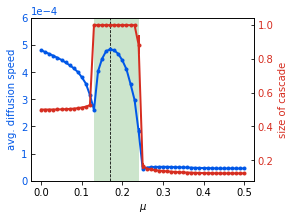

In [13]:
fig, ax = plt.subplots(figsize = (4, 3))

col1 = '#0057e7'

# standard error
ax.errorbar(us, avg_rates, yerr=CIs['95']*(std_rates/np.sqrt(num_runs)), color=col1, marker='o', linestyle='-', markersize = 3, linewidth = 2)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel('avg. diffusion speed', color=col1)
ax.tick_params(axis='y', labelcolor = col1, direction='in')
ax.axvspan(lower_u, upper_u, color='green', alpha=0.2, linewidth=0)
ax.axvline(optimal_u, color='k', linestyle='--', linewidth = 0.8)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylim([0, 6e-4])

col2 = '#d62d20'
ax2 = ax.twinx()
# ax2.get_shared_y_axes().join(ax, ax2)
ax2.errorbar(us, avg_sizes, yerr=CIs['95']*(std_sizes/np.sqrt(num_runs)), color=col2, marker='o', linestyle='-', markersize = 3, linewidth = 2)
ax2.set_ylabel('size of cascade', color=col2)
ax2.tick_params(axis='y', labelcolor = col2, direction='in')

# ax.set_title(r'$threshold={:.3}$'.format(thsh))
plt.show()
fig.savefig('mm_ltm_global_rate_size.pdf', bbox_inches='tight', pad_inches=0)

### Temporal speed and size

diffusion speed per time step

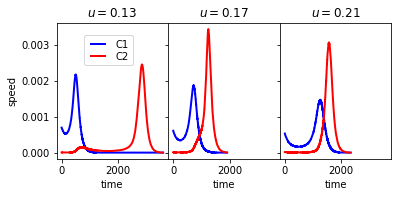

In [139]:
fig, axes = plt.subplots(1, len(cand_us), sharey=True, sharex=True, figsize = (6, 2.5))

colors = ['b', 'r']
labels = ['C1', 'C2']
for i, u in zip(range(len(cand_us)), cand_us):
    max_step = 0
    for size, step, _ in results[u]:
        if step > max_step:
            max_step = step
    xs = np.arange(max_step)
    for j, col, label in zip(range(num_community), colors, labels):
        mat = np.zeros((num_runs, max_step))
        for m in range(num_runs):
            activation_per_step = results[u][m][2][j]
            for n in range(len(activation_per_step)):
                mat[m, n] = activation_per_step[n]/(num_nodes*0.5)
        avg_speed_step = np.mean(mat, axis=0)
        axes[i].plot(xs[:-1], avg_speed_step[1:], label=label, color=col, linestyle='-', linewidth = 2)
        axes[i].set_xlabel(r'time')
        axes[i].set_title(r'$u={:3.2f}$'.format(u))
        
legend = axes[0].legend(loc='lower left', bbox_to_anchor=(0.2,0.65), labelspacing=0.2, frameon=True, numpoints=2, markerscale=1.2)
axes[0].set_ylabel(r'speed')
#axes[-1].set_xticks([0, 5, 10, 15, 20])
fig.subplots_adjust(wspace=0)
plt.show()
fig.savefig('mm_ltm_speed_per_step.pdf', bbox_inches='tight', pad_inches=0)

cascade size per time step

In [136]:
cand_us = [lower_u, optimal_u, 0.21]

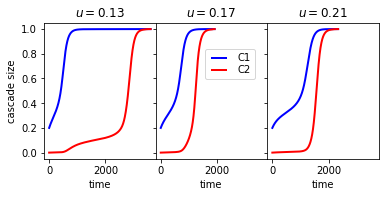

In [138]:
fig, axes = plt.subplots(1, len(cand_us), sharey=True, sharex=True, figsize = (6, 2.5))

colors = ['b', 'r']
labels = ['C1', 'C2']
for i, u in zip(range(len(cand_us)), cand_us):
    max_step = 0
    for size, step, _ in results[u]:
        if step > max_step:
            max_step = step
    xs = np.arange(max_step)
    for j, col, label in zip(range(num_community), colors, labels):
        mat = np.ones((num_runs, max_step))
        for m in range(num_runs):
            activation_per_step = results[u][m][2][j]
            cum_seq = np.cumsum(activation_per_step)/(num_nodes*0.5)
            for n in range(len(cum_seq)):
                mat[m, n] = cum_seq[n]
        avg_cum_seq = np.mean(mat, axis=0)
        axes[i].plot(xs, avg_cum_seq, label=label, color=col, linestyle='-', linewidth = 2)
        axes[i].set_xlabel(r'time')
        axes[i].set_title(r'$u={:3.2f}$'.format(u))
        #axes[i].set_xlim([0, 20])
        #axes[i].set_xticks([0, 5, 10, 15])
        
legend = axes[1].legend(loc='lower left', bbox_to_anchor=(0.4,0.55), labelspacing=0.2, frameon=True, numpoints=2, markerscale=1.2)
axes[0].set_ylabel(r'cascade size')
#axes[-1].set_xticks([0, 5, 10, 15, 20])
fig.subplots_adjust(wspace=0)
plt.show()
fig.savefig('mm_ltm_cum_size.pdf', bbox_inches='tight', pad_inches=0)